## Imports 

In [1]:
from caserec.recommenders.rating_prediction.nnmf import NNMF
from caserec.recommenders.rating_prediction.ae import AE
from keras import initializers

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Make the import
import os, sys
import pandas as pd
import joblib
import numpy as np
from caserec.utils.split_database import SplitDatabase
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import clear_output

lib_path = './../Sources/Utilities'
if (lib_path not in sys.path):
    sys.path.append(lib_path) #src directory

from messaging.print_functions import ProgressBar
from messaging.telegrambot import Bot
bot = Bot(user_credentials='./JFGS.json')

# Checking if bot is ok
bot.send_message(text="Hello, John")
progbar = ProgressBar(bar_length=20, bar_fill='#', elapsed_time=True)

## Setting Dataset

In [3]:
dataset, dataset_type = 'MovieLens', '100k'
# dataset, dataset_type = 'BookCrossing', 'Standard'
# dataset, dataset_type = 'Amazon', 'MoviesTV'
# dataset, dataset_type = 'Amazon', 'InstantVideo'
# dataset, dataset_type = 'Jester', 'jester'

dataset_folder = "../Datasets/" + dataset + "/" + dataset_type + "/"
dataset_output_folder = dataset_folder + 'outputs/'

df_overall_sparsity = pd.read_csv(dataset_output_folder + 'df_overall_sparsity.tsv', sep='\t', header=0)
df_overall_sparsity.head()

,uss_limit,iss_limit,os,num_users,num_items
0,0.1,0.10,0.000000,2.0,1.0
1,0.1,0.11,0.000000,2.0,1.0
2,0.1,0.12,0.000000,2.0,1.0
3,0.1,0.13,0.333333,2.0,3.0
4,0.1,0.14,0.250000,2.0,4.0


In [4]:
sparsity_datasets_folder = dataset_output_folder + 'sparsity_datasets/'
sparsity_folders = os.listdir(sparsity_datasets_folder)
if 'desktop.ini' in sparsity_folders:    
    sparsity_folders.remove('desktop.ini')

## Creating Evaluation Function

In [5]:

def eval_model(**kwargs):
    from random import choice
    from string import ascii_uppercase

    predictions_output_filepath = './predictions_output_' + ''.join(choice(ascii_uppercase) for i in range(12)) + '.dat'
    
    if (kwargs['model_name'].lower() == 'item-knn'):
        from caserec.recommenders.item_recommendation.itemknn import ItemKNN

        model = ItemKNN(
                        train_file=kwargs['train_filepath'], 
                        test_file=kwargs['test_filepath'], 
        #                 as_binary=True, # If True, the explicit feedback will be transform to binary
                        k_neighbors=kwargs['k_neighbors'],
                        similarity_metric=kwargs['similarity_metric'],
                        rank_length=kwargs['top_n'])

        model.compute(
            metrics=None, 
            as_table=True,
            n_ranks=[kwargs['top_n']],
            verbose=False)
        
        eval_results = model.evaluation_results

    elif (kwargs['model_name'].lower() == 'nnmf'):  
        from caserec.recommenders.rating_prediction.nnmf import NNMF
        from caserec.utils.process_data import ReadFile
        from caserec.evaluation.rating_prediction import RatingPredictionEvaluation
        
        predictions_output_filepath = './predictions_output.dat'
        
        model = NNMF(kwargs['train_filepath'], 
                      kwargs['test_filepath'], 
                      factors=kwargs['n_factors'],
                     output_file = predictions_output_filepath)
        
        model.compute(verbose=False)
        
        # Using ReadFile class to read predictions from file
        reader = ReadFile(input_file=predictions_output_filepath)
        predictions = reader.read()
        
        # Creating evaluator with item-recommendation parameters
        evaluator = RatingPredictionEvaluation(sep = '\t', 
                                               n_rank = [kwargs['top_n']], 
                                               as_rank = True,
                                               metrics = list(kwargs['metrics']))

        # Getting evaluation
        eval_results = evaluator.evaluate(predictions['feedback'], model.test_set)
        
        eval_results['MAE'] = model.evaluation_results['MAE']
        eval_results['RMSE'] = model.evaluation_results['RMSE']
        
    elif (kwargs['model_name'].lower() == 'ae'):  
        from caserec.recommenders.rating_prediction.ae import AE        
        from caserec.utils.process_data import ReadFile
        from caserec.evaluation.rating_prediction import RatingPredictionEvaluation
        
        model = AE(kwargs['train_filepath'], 
                   kwargs['test_filepath'], 
                   num_neurons=kwargs['num_neurons'],
                   kernel_initializer=kwargs['kernel_initializer'],
                   output_file = predictions_output_filepath)
        
        model.compute(verbose=False)
        
        # Using ReadFile class to read predictions from file
        reader = ReadFile(input_file=predictions_output_filepath)
        predictions = reader.read()
        
        # Creating evaluator with item-recommendation parameters
        evaluator = RatingPredictionEvaluation(sep = '\t', 
                                               n_rank = [kwargs['top_n']], 
                                               as_rank = True,
                                               metrics = list(kwargs['metrics']))

        # Getting evaluation
        eval_results = evaluator.evaluate(predictions['feedback'], model.test_set)    
        
        eval_results['MAE'] = model.evaluation_results['MAE']
        eval_results['RMSE'] = model.evaluation_results['RMSE']
        
    elif (kwargs['model_name'].lower() == 'bprmf'):  
        from caserec.recommenders.item_recommendation.bprmf import BprMF
        
        model = BprMF(kwargs['train_filepath'], 
                      kwargs['test_filepath'], 
                      batch_size=30, 
                      rank_length = kwargs['top_n'])
        
        model.compute(
            metrics=None, 
            as_table=True)
        
        eval_results = model.evaluation_results

    eval_results['uss_limit'] = kwargs['uss_limit']
    eval_results['iss_limit'] = kwargs['iss_limit']

    os.remove(predictions_output_filepath)
    
    return eval_results    


## Creating list of argument to evaluation function

In [79]:
top_n = 10
model_name = 'ae'
metrics = ('PREC', 'RECALL', 'NDCG', 'MAP')

# Item KNN Parameters
k_neighbors = 30
similarity_metric= 'cosine'
# NNMF Parameters
n_factors = 30
# Auto encoder parameters 
kernel_initializer=initializers.random_uniform()
num_neurons = 400

arr_eval_args = []

for index, row in df_overall_sparsity.iterrows():    
    progbar.update_progress(index/float(df_overall_sparsity.shape[0]))
        
#     if (index > 15):
#         break
        
    fold_num = 0
    n_folds = 2
    
    uss_limit = row['uss_limit']
    iss_limit = row['iss_limit']
    
#     if (int(100*uss_limit)%2 == 1) or (int(100*iss_limit)%2 == 1):
#         continue
    
    target_folder = 'usslimit_{}_isslimit_{}'.format(uss_limit, iss_limit)

    if target_folder not in sparsity_folders:
        print ("Error findind " + target_folder + " folder")    
        break
    else:        
        # Visualize file content
        ratings_filepath = sparsity_datasets_folder + target_folder + '/u.data'
        cross_validation_folder = sparsity_datasets_folder + target_folder + '/'

        try:
        
            SplitDatabase(input_file=ratings_filepath, dir_folds = cross_validation_folder, n_splits=n_folds).k_fold_cross_validation()

        except : 
            print ("Erro em ", ratings_filepath)
            break
            
        fold_path = cross_validation_folder + 'folds/' + str(fold_num)

        train_filepath = fold_path + '/train.dat'
        test_filepath = fold_path + '/test.dat'

        temp_eval_args = {'uss_limit': uss_limit,
                          'iss_limit': iss_limit,
                          'model_name': model_name,                           
                          'metrics': metrics,
                          'train_filepath': train_filepath, 
                          'test_filepath': test_filepath, 
                          'top_n': top_n, 
#                           'k_neighbors': k_neighbors, # KNN
#                           'similarity_metric': similarity_metric, # KNN
#                           'n_factors': n_factors, # NNMF
                          'kernel_initializer': kernel_initializer, # AE
                          'num_neurons': num_neurons # AE
                         }

        arr_eval_args.append(temp_eval_args)

text = "Finished creating arr_eval_args for {} on {}/{} dataset in {}".format(model_name, dataset, dataset_type, progbar.get_elapsed_time())
joblib.dump(arr_eval_args, dataset_output_folder + 'arr_eval_args_' + model_name + '.joblib')
bot.send_message(text=text)

[0:51:41][####################] 99.99% 

In [80]:
def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out

In [81]:
len(arr_eval_args)

8281

In [84]:
n_chunks = 10
arr_chunks_eval_args = chunkIt(arr_eval_args, n_chunks)
joblib.dump(arr_chunks_eval_args, dataset_output_folder + 'arr_' + str(n_chunks) + '_chunks_eval_args_' + model_name + '.joblib')

['../Datasets/MovieLens/100k/outputs/arr_10_chunks_eval_args_ae.joblib']

In [9]:
model_name = 'ae'
n_chunks = 10
chunk_number = 0
arr_chunks_eval_args = joblib.load(dataset_output_folder + 'arr_' + str(n_chunks) + '_chunks_eval_args_' + model_name + '.joblib')

In [10]:
len(arr_chunks_eval_args[chunk_number])

828

### Testing evaluation function

In [12]:
%%time
eval_model(**arr_chunks_eval_args[chunk_number][0])

Eval:: MAE: 1.0 RMSE: 1.0 
Eval:: PREC@10: 0.1 RECALL@10: 1.0 NDCG@10: 1.0 MAP@10: 1.0 
Wall time: 1.7 s


{'MAE': 1.0,
 'MAP': 1.0,
 'MAP@10': 1.0,
 'NDCG@10': 1.0,
 'PREC@10': 0.1,
 'RECALL@10': 1.0,
 'RMSE': 1.0,
 'iss_limit': 0.1,
 'uss_limit': 0.1}

In [78]:
bot.send_message(text='Started creating df_eval_metadata for chunk number ' + str(chunk_number))
max_evals = len(arr_chunks_eval_args[chunk_number])
for index, row in enumerate(arr_chunks_eval_args[chunk_number]):
    current_save = int(10*index/float(max_evals)) 
    
    clear_output()
    progbar.update_progress(index/float(max_evals))    

    print (row)
    
#     if (index >= 15):
#         break
    
    eval_result = eval_model(**arr_chunks_eval_args[chunk_number][index])

    if (index == 0):
        colnames = list(eval_result.keys())
        df_eval_metadata = pd.DataFrame(columns = colnames)
        
    df_eval_metadata.loc[index] = [eval_result[x] for x in colnames]

df_eval_metadata.to_csv(dataset_output_folder + 'df_eval_metadata_' + model_name + '_chunk_' + str(chunk_number) + '.tsv', sep = '\t', header = 1, index = 0 )
text = "Finished creating df_eval_metadata for {} on {}/{} dataset (chunk #{})".format(model_name, dataset, dataset_type, chunk_number)
bot.send_message(text=text)
# import os
# os.system('shutdown -s')

[12:16:07][###-----------------] 15.17% {'uss_limit': 0.24, 'iss_limit': 0.22, 'model_name': 'ae', 'metrics': ('PREC', 'RECALL', 'NDCG', 'MAP'), 'train_filepath': '../Datasets/MovieLens/100k/outputs/sparsity_datasets/usslimit_0.24_isslimit_0.22/folds/0/train.dat', 'test_filepath': '../Datasets/MovieLens/100k/outputs/sparsity_datasets/usslimit_0.24_isslimit_0.22/folds/0/test.dat', 'top_n': 10, 'kernel_initializer': <keras.initializers.RandomUniform object at 0x0000016DF4826F28>, 'num_neurons': 400}


KeyboardInterrupt: 

In [66]:
df_eval_metadata.tail()

,PREC@10,RECALL@10,NDCG@10,MAP@10,MAP,MAE,RMSE,uss_limit,iss_limit
10,0.10,1.0,0.815465,0.666667,0.666667,0.960236,1.095894,0.1,0.20
11,0.05,0.5,0.500000,0.500000,0.500000,1.201220,1.266085,0.1,0.21
12,0.15,1.0,0.815465,0.666667,0.666667,1.120125,1.232178,0.1,0.22
13,0.15,1.0,1.000000,0.750000,0.750000,1.166957,1.261977,0.1,0.23
14,0.15,0.5,0.500000,0.500000,0.500000,1.165697,1.469923,0.1,0.24


In [15]:
df_eval_metadata.to_csv(dataset_output_folder + 'df_eval_metadata_' + model_name + '.tsv', sep = '\t', header = 1, index = 0 )

### Checking memory usage

In [ ]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In [17]:
top_n = 10

## Plotting Results

### Ranking Metrics

In [22]:
arr_rank_metrics = ['PREC@' + str(top_n), 'RECALL@' + str(top_n), 'NDCG@' + str(top_n), 'MAP@' + str(top_n)]

In [18]:
uss_limits = df_eval_metadata['uss_limit'].unique()
iss_limits = df_eval_metadata['iss_limit'].unique()

# column = 'MAP@10'
arr_rank_metrics = ['PREC@' + str(top_n), 'RECALL@' + str(top_n), 'NDCG@' + str(top_n), 'MAP@' + str(top_n)]

for column in arr_rank_metrics:

    arr_prec = np.zeros([len(uss_limits), len(iss_limits)])
    for uss_index, uss_limit in enumerate(uss_limits):
        for iss_index, iss_limit in enumerate(iss_limits):
            arr_prec[uss_index, iss_index] = df_eval_metadata[(df_overall_sparsity['uss_limit'] == uss_limit) & (df_overall_sparsity['iss_limit'] == iss_limit)][column].reset_index(drop = True)[0]

    joblib.dump(arr_prec, dataset_output_folder + 'arr_' + column.lower() + '_' + model_name + '.joblib')        

[*] Saving 2d-PREC@10-nnmf.png figure to ../Datasets/MovieLens/100k/outputs/Figures/ folder...
[+] Results saved.
[*] Saving 2d-RECALL@10-nnmf.png figure to ../Datasets/MovieLens/100k/outputs/Figures/ folder...
[+] Results saved.
[*] Saving 2d-NDCG@10-nnmf.png figure to ../Datasets/MovieLens/100k/outputs/Figures/ folder...
[+] Results saved.
[*] Saving 2d-MAP@10-nnmf.png figure to ../Datasets/MovieLens/100k/outputs/Figures/ folder...
[+] Results saved.


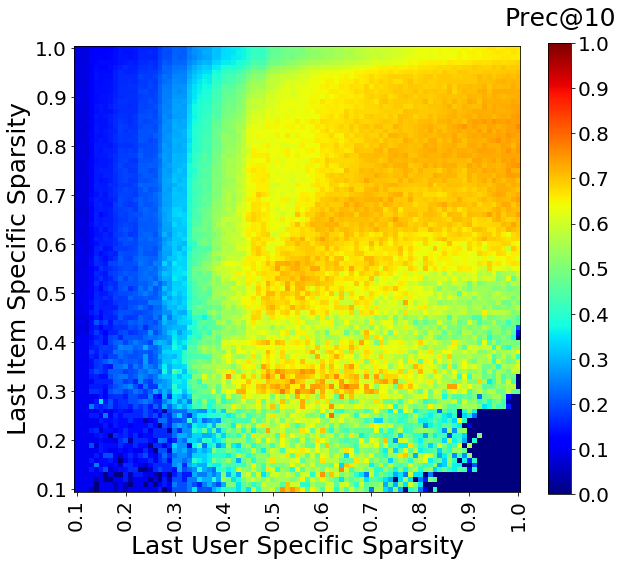

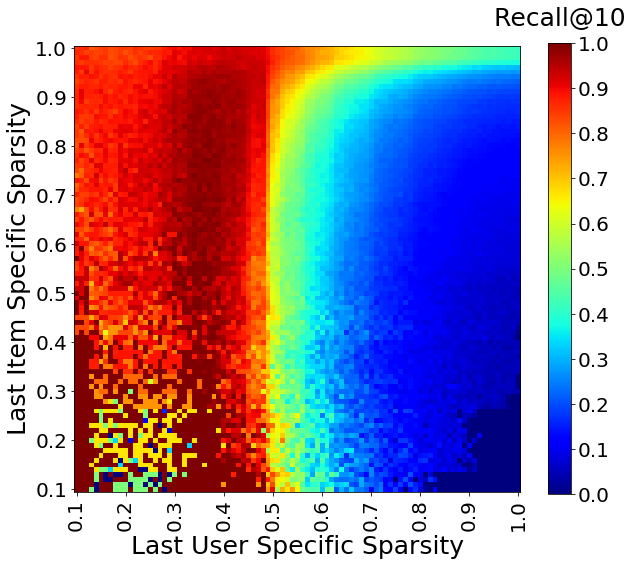

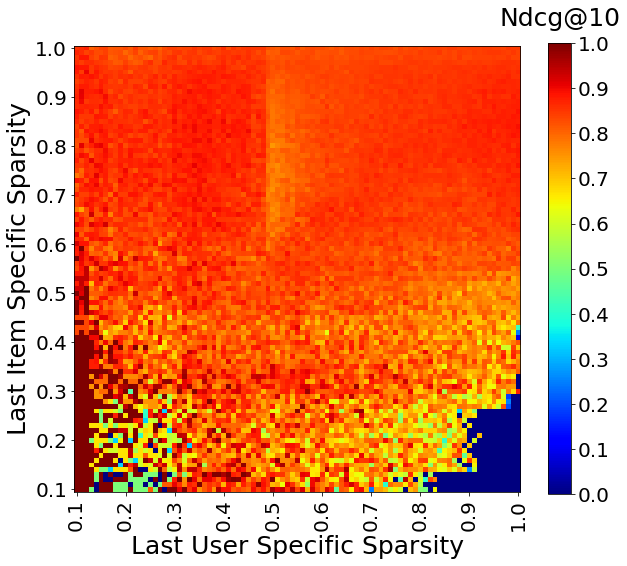

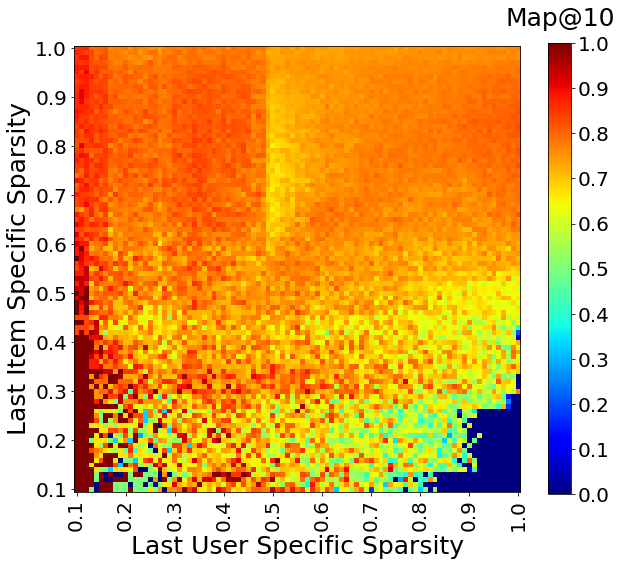

In [23]:
for column in arr_rank_metrics:

    arr_prec = joblib.load(dataset_output_folder + 'arr_' + column.lower() + '_' + model_name + '.joblib')        

    cmapping = "jet"
    fig, ax = plt.subplots(figsize=(10,10))

    # plt.subplot(1, 1, 1)
    cax = plt.imshow(arr_prec, cmap=cmapping)
    plt.gca().invert_yaxis()
    cbar = plt.colorbar(cax, ticks = [x/100.0 for x in np.arange(0,1000,10)], shrink = 0.83)
    # plt.colorbar.set_label('OS', labelpad=-50,  y=1.05, rotation=0, fontsize = label_fontsize)

    tick_step = int(10)

    ax.set_xticklabels(uss_limits[0:len(uss_limits):tick_step])
    ax.set_yticklabels(iss_limits[0:len(uss_limits):tick_step])

    plt.xticks(np.arange(0, len(uss_limits), tick_step))
    plt.yticks(np.arange(0, len(iss_limits), tick_step))

    plt.clim(0, 1)


    tick_fontsize = 20
    label_fontsize = 25

    # # Setting Labels
    ax.set_xlabel('Last User Specific Sparsity', fontsize = label_fontsize)
    ax.set_ylabel('Last Item Specific Sparsity', fontsize = label_fontsize)
    # cbar = fig.colorbar(cax, ticks = [x/100.0 for x in np.arange(0,1000,5)])

    plt.xticks(rotation = 'vertical')
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    cbar.set_label(column.title(), labelpad=-50,  y=1.08, rotation=0, fontsize = label_fontsize)
    cbar.ax.tick_params(labelsize = tick_fontsize)


    # Saving figure
    filename = '2d-' + column + '-' + model_name + '.png';
    fullpath = dataset_output_folder+'Figures/';
    print ("[*] Saving " + filename + " figure to " + fullpath + " folder...")
    fig.savefig(fullpath + filename, bbox_inches = 'tight')
    print ("[+] Results saved.")
    
#     bot.send_photo(bot_credentials['chat_id'], photo=open(fullpath + filename, 'rb'))

### Rating Prediction Metrics 

In [24]:
arr_rating_metrics = ['RMSE', 'MAE']

In [ ]:
uss_limits = df_eval_metadata['uss_limit'].unique()
iss_limits = df_eval_metadata['iss_limit'].unique()

# column = 'MAP@10'
arr_rating_metrics = ['RMSE', 'MAE']

for column in arr_rating_metrics:

    arr_prec = np.zeros([len(uss_limits), len(iss_limits)])
    for uss_index, uss_limit in enumerate(uss_limits):
        for iss_index, iss_limit in enumerate(iss_limits):
            arr_prec[uss_index, iss_index] = df_eval_metadata[(df_overall_sparsity['uss_limit'] == uss_limit) & (df_overall_sparsity['iss_limit'] == iss_limit)][column].reset_index(drop = True)[0]

    joblib.dump(arr_prec, dataset_output_folder + 'arr_' + column.lower() + '_' + model_name + '.joblib')        

In [30]:
arr_prec.max()

2.001115

[*] Saving 2d-RMSE-nnmf.png figure to ../Datasets/MovieLens/100k/outputs/Figures/ folder...
[+] Results saved.
[*] Saving 2d-MAE-nnmf.png figure to ../Datasets/MovieLens/100k/outputs/Figures/ folder...
[+] Results saved.


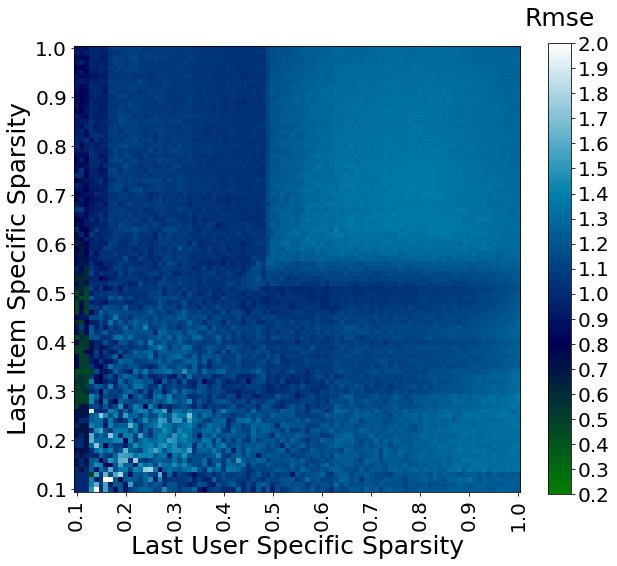

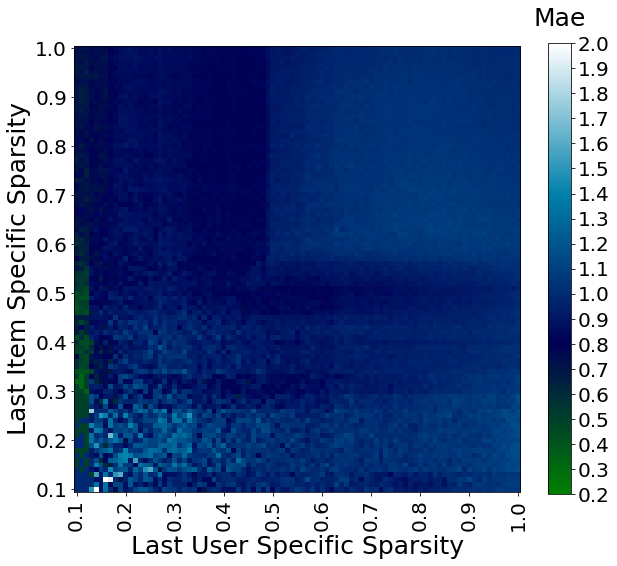

In [51]:
for column in arr_rating_metrics:

    arr_prec = joblib.load(dataset_output_folder + 'arr_' + column.lower() + '_' + model_name + '.joblib')        

    cmapping = "ocean"
    fig, ax = plt.subplots(figsize=(10,10))

    # plt.subplot(1, 1, 1)
    cax = plt.imshow(arr_prec, cmap=cmapping)
    plt.gca().invert_yaxis()
    cbar = plt.colorbar(cax, ticks = [x/100.0 for x in np.arange(0,1000,10)], shrink = 0.83)
    # plt.colorbar.set_label('OS', labelpad=-50,  y=1.05, rotation=0, fontsize = label_fontsize)

    tick_step = int(10)

    ax.set_xticklabels(uss_limits[0:len(uss_limits):tick_step])
    ax.set_yticklabels(iss_limits[0:len(uss_limits):tick_step])

    plt.xticks(np.arange(0, len(uss_limits), tick_step))
    plt.yticks(np.arange(0, len(iss_limits), tick_step))

    plt.clim(0.2, 2)


    tick_fontsize = 20
    label_fontsize = 25

    # # Setting Labels
    ax.set_xlabel('Last User Specific Sparsity', fontsize = label_fontsize)
    ax.set_ylabel('Last Item Specific Sparsity', fontsize = label_fontsize)
    # cbar = fig.colorbar(cax, ticks = [x/100.0 for x in np.arange(0,1000,5)])

    plt.xticks(rotation = 'vertical')
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    cbar.set_label(column.title(), labelpad=-50,  y=1.08, rotation=0, fontsize = label_fontsize)
    cbar.ax.tick_params(labelsize = tick_fontsize)


    # Saving figure
    filename = '2d-' + column + '-' + model_name + '.png';
    fullpath = dataset_output_folder+'Figures/';
    print ("[*] Saving " + filename + " figure to " + fullpath + " folder...")
    fig.savefig(fullpath + filename, bbox_inches = 'tight')
    print ("[+] Results saved.")
    
#     bot.send_photo(bot_credentials['chat_id'], photo=open(fullpath + filename, 'rb'))

In [ ]:
eval_model(**temp_eval_args)    

In [ ]:
df_ratings.head()

In [ ]:
sparsity_folders

In [ ]:
# filepath = "{}ratings.csv".format(folder)
# output_folder = '../Datasets/' + dataset + '/' + dataset_type + '/outputs/'
# dataset_output_folder = output_folder + 'sparsity_dataset/'

# # Visualize file content
# # df_whole = pd.read_csv(filepath, sep='\t', header=0, names=['user_id', 'item_id', 'rating', 'timestamp']) 
# df_whole = pd.read_csv(filepath, sep='\t', header=0) 
# df_whole.head()

In [ ]:

if not os.path.exists(dataset_output_folder):
    os.makedirs(dataset_output_folder)

## Autoencoder Analysis 

In [ ]:
import os
os.listdir(dataset_folder)

In [ ]:
dataset_folder

In [ ]:

analysis_folder = sparsity_datasets_folder + sparsity_folders[-1] + '/folds/0/'

tr = analysis_folder + 'train.dat'
te = analysis_folder + 'train.dat'

model = AE(tr, te, kernel_initializer=initializers.random_uniform())
model.compute(verbose=True)

In [ ]:
step_size = 10
max_percentage = 0.8
array_eval_neurons = []
array_neurons = np.arange(10, int(max_percentage*len(model.items)), step_size)

for index, num_neurons in enumerate(array_neurons):
    clear_output()
    progbar.update_progress(index/float(len(array_neurons)))    
    
    model = AE(tr, te, num_neurons=num_neurons, kernel_initializer=initializers.random_uniform())
    model.compute(verbose=True)
    
    line = [num_neurons, model.evaluation_results['MAE'], model.evaluation_results['RMSE']]
    array_eval_neurons.append(line)
    
bot.send_message('Finished analsys RMSE and MAE for AutoEncoder')

In [ ]:
model_name = 'ae'
df_eval_neurons = pd.DataFrame(data=array_eval_neurons, columns=['neurons', 'MAE', 'RMSE'])
df_eval_neurons.to_csv(dataset_output_folder + 'df_eval_neurons_' + model_name + '.tsv', sep='\t', header=True)
df_eval_neurons.head()


In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,10))
ax.plot(df_eval_neurons['neurons'], df_eval_neurons['MAE'], label='MAE')
ax.plot(df_eval_neurons['neurons'], df_eval_neurons['RMSE'], label='RMSE')
ax.legend()
ax.grid()
ax.set_title('Metrics x Number of Neurons')
ax.set_xlabel('Number of Neurons')

# Saving figure
filename = 'mae_rmse_x_num_neurons' + '-' + model_name + '.png';
fullpath = dataset_output_folder+'Figures/';
print ("[*] Saving " + filename + " figure to " + fullpath + " folder...")
fig.savefig(fullpath + filename, bbox_inches = 'tight')
print ("[+] Results saved.")

